In [33]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from utils import chart_price, plot, perf, v_backtester, c_backtester, perf_var, summary
import sys
sys.path.append('/home/tomek/ib_tools')
import matplotlib.pyplot as plt
%matplotlib inline
from tester import get_data
from numba import jit
from typing import Optional, Union, List

In [2]:
df = get_data('NQ')
df = df.loc['20180901': '20190331']

In [3]:
df

,open,high,low,close,volume,average,barCount
date,,,,,,,
2018-09-03 00:00:00,7670.00,7675.00,7670.00,7671.50,166,7672.550,104
2018-09-03 00:01:00,7671.50,7672.75,7670.00,7670.00,84,7671.675,60
2018-09-03 00:02:00,7670.00,7671.00,7669.75,7671.00,28,7670.250,21
2018-09-03 00:03:00,7671.25,7672.25,7671.25,7671.75,45,7671.850,31
2018-09-03 00:04:00,7672.00,7672.00,7669.75,7669.75,32,7670.775,26
...,...,...,...,...,...,...,...
2019-03-29 21:55:00,7413.50,7413.75,7410.50,7410.75,102,7412.175,58
2019-03-29 21:56:00,7411.25,7411.50,7410.00,7410.50,71,7410.850,52
2019-03-29 21:57:00,7410.50,7412.75,7409.50,7412.75,71,7410.650,47


In [4]:
dfp = df[[ 'high', 'low',]]
n = dfp.to_numpy()
n.shape

(200265, 2)

In [5]:
@jit(nopython=True)
def swing(data: np.array, f: float) -> np.array:
    extreme = data[0,0]
    state = np.ones((data.shape[0], 1))
    for i, row in enumerate(data):
        if i == 0:
            continue
        #print(f'{i} extreme: {extreme}, row: {row}')
        if state[i-1, 0] == 1:
            if extreme - row[1] > f:
                state[i] = -1
                extreme = row[1]
            else:
                state[i] = 1
                extreme = max(extreme, row[0])
        elif state[i-1, 0] == -1:
            if row[0] - extreme > f:
                state[i] = 1
                extreme = row[0]
            else:
                state[i, 0] = -1
                extreme = min(extreme, row[1])
        else:
            raise ValueError('Wrong state value!')
        #print(f'state: {state[i,0]}')
        #print('---------------')
    return state

In [6]:
@jit(nopython=True)
def swing_1(data: np.array, f: float) -> np.array:
    state = np.ones((data.shape[0], 1))
    extreme = np.zeros(state.shape)
    extreme[0] = data[0,0]
    for i, row in enumerate(data):
        if i == 0:
            continue
        #print(f'{i} extreme: {extreme}, row: {row}')
        if state[i-1, 0] == 1:
            if extreme[i-1, 0] - row[1] > f:
                state[i] = -1
                extreme[i] = row[1]
            else:
                state[i] = 1
                extreme[i] = max(extreme[i-1, 0], row[0])
        elif state[i-1, 0] == -1:
            if np.abs(extreme[i-1, 0] - row[0]) > f:
                state[i] = 1
                extreme[i] = row[0]
            else:
                state[i, 0] = -1
                extreme[i] = min(extreme[i-1, 0], row[1])
        else:
            raise ValueError('Wrong state value!')
        #print(f'state: {state[i,0]}')
        #print('---------------')
    return np.concatenate((state, extreme), axis=1)

In [296]:
@jit(nopython=True)
def swing_2(data: np.array, f: float) -> np.array:
    state = np.ones((data.shape[0], 1), dtype=np.int8)
    extreme = np.zeros(state.shape)
    extreme[0] = data[0,0]
    pivot = np.zeros(state.shape)
    pivot[0] = data[0, 0]
    signal = np.ones(state.shape, dtype=np.int8)
    signal[0] = 1
    max_pivot = np.array([data[0, 0]])
    min_pivot = np.array([data[0, 1]])
    max_list = np.zeros(state.shape)
    min_list = np.zeros(state.shape)
    for i, row in enumerate(data):
        #print(f'{i} row: {row}, extreme: {extreme[i-1]}')
        if i == 0:
            continue          

        if state[i-1, 0] == 1:   
            if (row[0] > max_pivot[0]): 
                signal[i] = 1
            else:
                signal[i] = signal[i-1]
                
            if extreme[i-1, 0] - row[1] > f:
                state[i] = -1
                extreme[i] = row[1]
                pivot[i] = extreme[i-1]
                max_pivot = pivot[i]
                max_list[i] = max_pivot
            else:
                state[i] = 1
                extreme[i] = max(extreme[i-1, 0], row[0])
                pivot[i] = pivot[i-1]
            
        elif state[i-1, 0] == -1:  
            if (row[1] < min_pivot[0]):
                signal[i] = -1
            else:
                signal[i] =signal[i-1]
                
            if np.abs(extreme[i-1, 0] - row[0]) > f:
                state[i] = 1
                extreme[i] = row[0]
                pivot[i] = extreme[i-1]
                min_pivot = pivot[i]
                min_list[i] = min_pivot
            else:
                state[i, 0] = -1
                extreme[i] = min(extreme[i-1, 0], row[1])
                pivot[i] = pivot[i-1]
            
            
        else:
            raise ValueError('Wrong state value!')
        #print(f'pivot: {pivot[i]}, extreme: {extreme[i]}, signal: {signal[i]}, state: {state[i,0]}')
        #print(f'min_pivot: {min_pivot}, max_pivot: {max_pivot}')      
        #print('---------------')
    return np.concatenate((state, extreme, pivot, signal, max_list, min_list), axis=1)

In [ ]:
df[['swing', 'extreme']] = swing_1(n, 300)
#df['swing'] = swing(n, 200)

In [ ]:
summary(df['close'], df['swing'], slip=1.5).stats

In [ ]:
df['pivot'] = (df['swing'] != df['swing'].shift()) * 1
df['p_price'] = df['pivot'] * df['extreme'].shift().fillna(method='bfill')
df['t_price'] = df['pivot'] * df['close']
#df['p_price'] = df['p_price'].replace(0, np.nan)
df

In [ ]:
chart_price(p['close'], p['swing']);

In [ ]:
swing = df[df['p_price'] != 0].loc[:,['p_price', 't_price']]
swing.reset_index(drop=True, inplace=True)
swing

In [ ]:
swing.plot(figsize=(20,10), grid=True);

In [ ]:
swing.head(20)

In [ ]:
new_df = get_data('NQ')
n = new_df[['high', 'low']].to_numpy()

In [ ]:
for i in range(20, 400, 20):
    new_df[f's_{i}'] = swing(n, i)

In [ ]:
new_df

In [42]:
def sim(price, indicator, slip=1.5, threshold=0):
    b = v_backtester(price, indicator, threshold)
    r = perf_var(b, False, slippage=slip)
    return r.stats, r.daily['returns']

In [ ]:
stats = pd.DataFrame()
dfs = pd.DataFrame()
for i in range(20, 400, 20):
    stats[i], dfs[i] = sim(new_df['close'], new_df[f's_{i}'])

In [ ]:
stats

In [ ]:
dfs

In [ ]:
dfs.corr()

In [ ]:
def combine(df, i, j):
    c = df[['close', f's_{i}', f's_{j}']]
    c['combined'] = (c[f's_{i}'] + c[f's_{j}']).clip(-1, 1)
    return c

In [ ]:
c = combine(new_df, 120, 300)
summary(c['close'], c['combined'], slip=1.5).stats

In [313]:
df3[['swing', 'extreme', 'pivot', 'signal', 'max_list', 'min_list']] = swing_2(df3[['high', 'low']].to_numpy(), 75)
df3[['max_list', 'min_list']] = df3[['max_list', 'min_list']].replace(0.0, np.nan)
df3[['max_list', 'min_list']] = df3[['max_list', 'min_list']].fillna(method='ffill')
df3

,open,high,low,close,volume,average,barCount,swing,extreme,pivot,signal,max_list,min_list
date,,,,,,,,,,,,,
2018-09-03 00:00:00,7670.00,7675.00,7670.00,7671.50,166,7672.550,104,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:01:00,7671.50,7672.75,7670.00,7670.00,84,7671.675,60,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:02:00,7670.00,7671.00,7669.75,7671.00,28,7670.250,21,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:03:00,7671.25,7672.25,7671.25,7671.75,45,7671.850,31,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:04:00,7672.00,7672.00,7669.75,7669.75,32,7670.775,26,1.0,7675.0,7675.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-29 21:55:00,7413.50,7413.75,7410.50,7410.75,102,7412.175,58,1.0,7414.5,7276.0,-1.0,7447.5,7276.0
2019-03-29 21:56:00,7411.25,7411.50,7410.00,7410.50,71,7410.850,52,1.0,7414.5,7276.0,-1.0,7447.5,7276.0
2019-03-29 21:57:00,7410.50,7412.75,7409.50,7412.75,71,7410.650,47,1.0,7414.5,7276.0,-1.0,7447.5,7276.0


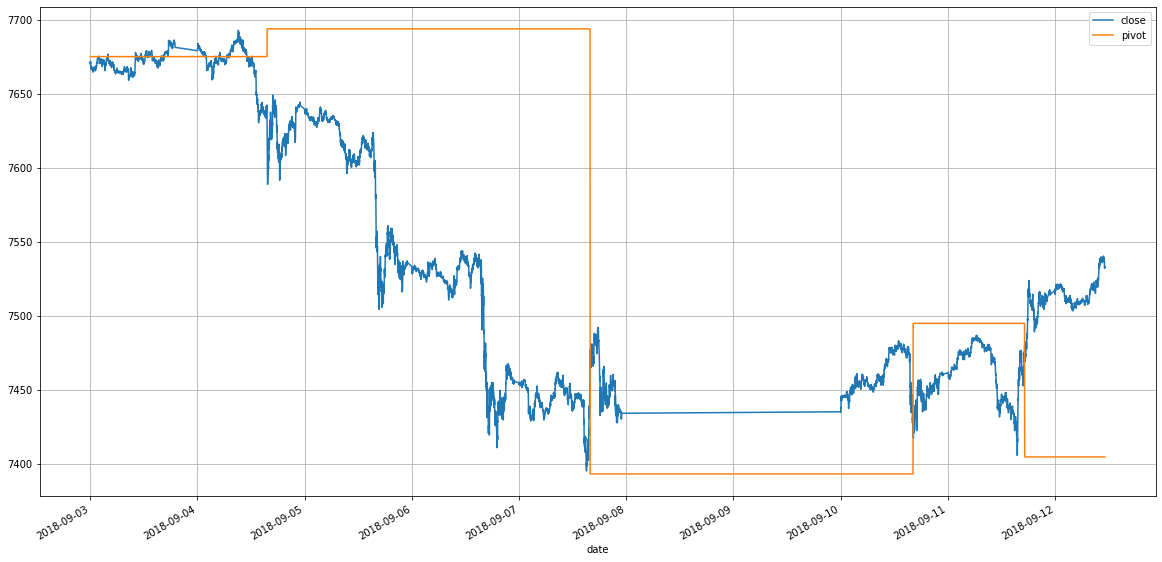

In [314]:
t = df3.iloc[:10000]
t[['close', 'pivot']].plot(figsize=(20,10), grid=True);

In [315]:
r[2]

,date_o,open,date_c,close,pnl,duration
0,2018-09-03 00:01:00,7670.00,2018-09-04 13:22:00,-7647.25,-23.50,1 days 13:21:00
1,2018-09-04 13:22:00,-7647.25,2018-09-07 15:55:00,7469.00,177.50,3 days 02:33:00
2,2018-09-07 15:55:00,7469.00,2018-09-10 16:11:00,-7424.50,-45.25,3 days 00:16:00
3,2018-09-10 16:11:00,-7424.50,2018-09-11 05:25:00,7484.50,-60.75,0 days 13:14:00
4,2018-09-11 05:25:00,7484.50,2018-09-11 15:33:00,-7405.50,-79.75,0 days 10:08:00
...,...,...,...,...,...,...
156,2019-03-11 13:48:00,7077.50,2019-03-22 20:38:00,-7377.00,298.75,11 days 06:50:00
157,2019-03-22 20:38:00,-7377.00,2019-03-26 00:57:00,7366.25,10.00,3 days 04:19:00
158,2019-03-26 00:57:00,7366.25,2019-03-27 16:14:00,-7333.00,-34.00,1 days 15:17:00
159,2019-03-27 16:14:00,-7333.00,2019-03-28 14:28:00,7346.00,-13.75,0 days 22:14:00


In [186]:
def swing_chart_data(df: pd.DataFrame, keep_columns: Optional[Union[List, str]] = None) -> pd.DataFrame:
    df = df.copy()
    df['swing_point'] = (df['swing'] != df['swing'].shift()) * 1
    df['swing_price'] = df['swing_point'] * df['extreme'].shift().fillna(method='bfill')
    df['close_price'] = df['swing_point'] * df['close']
    output_columns = ['swing_price', 'close_price']
    if keep_columns:
        if isinstance(keep_columns, str):
            keep_columns = [keep_columns]
        output_columns.extend(keep_columns)
    swing_df = df[df['swing_price'] != 0].loc[:, output_columns]
    swing_df.reset_index(drop=True, inplace=True)
    return swing_df

In [301]:
d = swing_chart_data(t, ['pivot'])
d

,swing_price,close_price,pivot
0,7675.00,7671.50,7675.00
1,7693.75,7642.75,7693.75
2,7586.75,7637.50,7586.75
3,7650.00,7593.00,7650.00
4,7590.50,7641.00,7590.50
5,7644.75,7594.50,7644.75
6,7503.25,7556.00,7503.25
7,7561.50,7516.00,7561.50
8,7407.75,7456.75,7407.75
9,7470.25,7417.00,7470.25


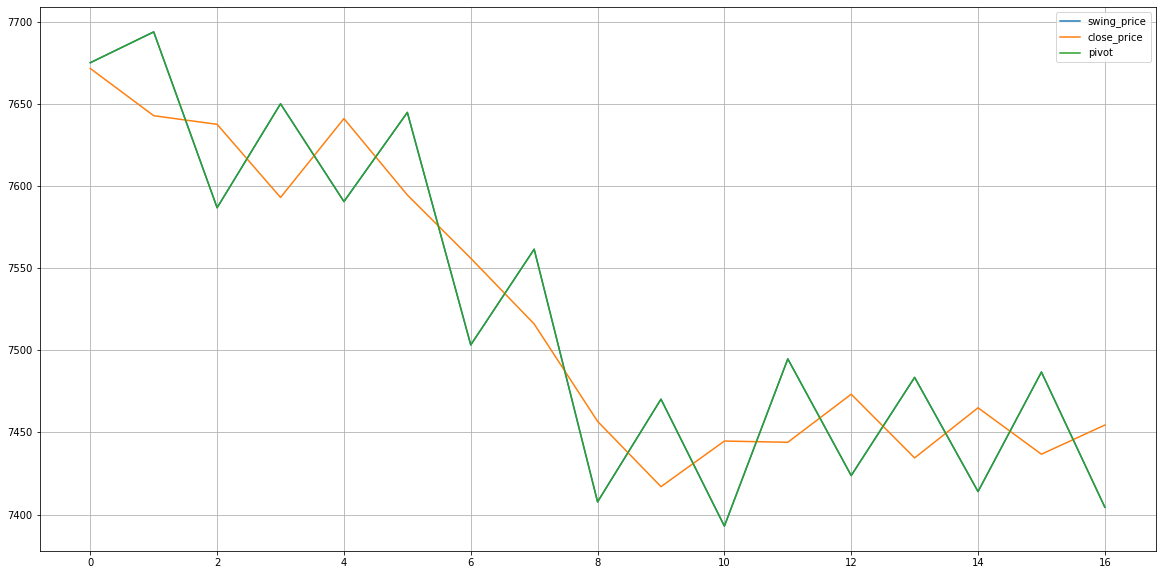

In [316]:
d.plot(figsize=(20,10), grid=True);

In [303]:
df3

,open,high,low,close,volume,average,barCount,swing,extreme,pivot,signal,max_list,min_list
date,,,,,,,,,,,,,
2018-09-03 00:00:00,7670.00,7675.00,7670.00,7671.50,166,7672.550,104,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:01:00,7671.50,7672.75,7670.00,7670.00,84,7671.675,60,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:02:00,7670.00,7671.00,7669.75,7671.00,28,7670.250,21,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:03:00,7671.25,7672.25,7671.25,7671.75,45,7671.850,31,1.0,7675.0,7675.0,1.0,NaN,NaN
2018-09-03 00:04:00,7672.00,7672.00,7669.75,7669.75,32,7670.775,26,1.0,7675.0,7675.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-29 21:55:00,7413.50,7413.75,7410.50,7410.75,102,7412.175,58,1.0,7414.5,7301.5,1.0,7372.5,7301.5
2019-03-29 21:56:00,7411.25,7411.50,7410.00,7410.50,71,7410.850,52,1.0,7414.5,7301.5,1.0,7372.5,7301.5
2019-03-29 21:57:00,7410.50,7412.75,7409.50,7412.75,71,7410.650,47,1.0,7414.5,7301.5,1.0,7372.5,7301.5


In [304]:
#df3['signal'] = df3['close'] < df3['pivot']

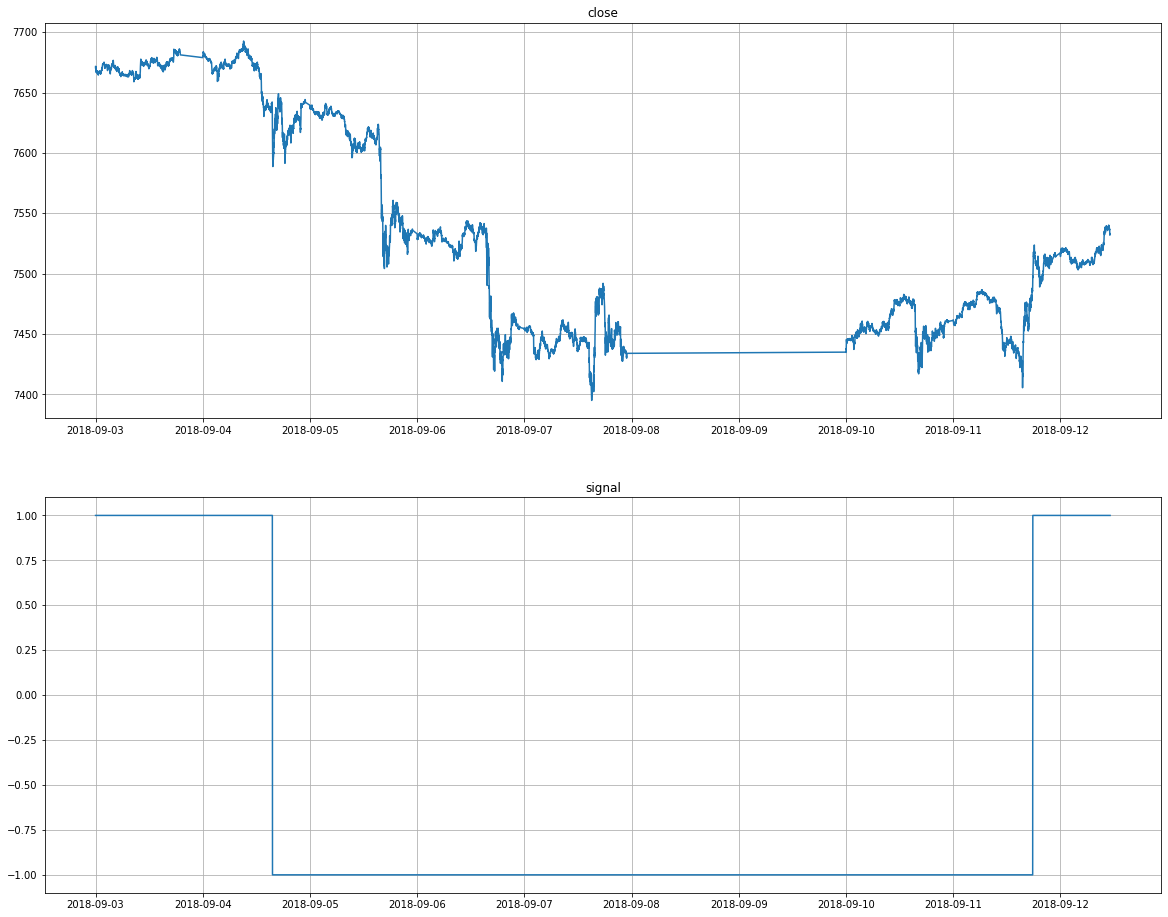

In [317]:
plot(df3[['close', 'signal']].iloc[:10000]);

In [318]:
b = v_backtester(df3['close'], df3['signal'], 0)
r = perf_var(b, False, slippage=1.5)

In [319]:
r[2]

,date_o,open,date_c,close,pnl,duration
0,2018-09-03 00:01:00,7670.00,2018-09-04 15:37:00,-7614.75,-56.00,1 days 15:36:00
1,2018-09-04 15:37:00,-7614.75,2018-09-11 17:51:00,7498.00,116.00,7 days 02:14:00
2,2018-09-11 17:51:00,7498.00,2018-09-18 01:50:00,-7424.00,-74.75,6 days 07:59:00
3,2018-09-18 01:50:00,-7424.00,2018-09-20 14:10:00,7566.75,-143.50,2 days 12:20:00
4,2018-09-20 14:10:00,7566.75,2018-10-04 03:37:00,-7630.75,63.25,13 days 13:27:00
...,...,...,...,...,...,...
59,2019-03-07 15:38:00,-7079.25,2019-03-11 20:14:00,7182.00,-103.50,4 days 04:36:00
60,2019-03-11 20:14:00,7182.00,2019-03-22 20:42:00,-7365.25,182.50,11 days 00:28:00
61,2019-03-22 20:42:00,-7365.25,2019-03-26 01:41:00,7375.00,-10.50,3 days 04:59:00
62,2019-03-26 01:41:00,7375.00,2019-03-27 16:36:00,-7298.25,-77.50,1 days 14:55:00


In [320]:
r[0]

Annual return                 0.0435193
Cumulative returns             0.025334
Annual volatility              0.224862
Sharpe ratio                   0.301172
Calmar ratio                   0.373327
Stability                      0.372423
Max drawdown                  -0.116572
Omega ratio                     1.05389
Sortino ratio                  0.431588
Skew                         -0.0206476
Kurtosis                         1.8179
Tail ratio                      1.06382
Daily value at risk          -0.0280613
Win percent                      0.4375
Average gain                    117.116
Average loss                   -84.7083
Avg gain/loss ratio             1.38258
Position EV                     3.58984
Positions per day              0.432432
Days per position                2.3125
Actual avg. duration    3 days 05:58:00
Days                                148
Positions                            64
Trades                              127
Monthly EV                      32.5997


In [339]:
df4=df3.copy()
df4[['swing', 'extreme', 'pivot', 'signal', 'max_list', 'min_list']] = swing_2(df3[['high', 'low']].to_numpy(), 75)

In [340]:
b = v_backtester(df4['close'], df4['signal'], 0)
r = perf_var(b, False, slippage=1.5)
r[0]

Annual return                 0.0435193
Cumulative returns             0.025334
Annual volatility              0.224862
Sharpe ratio                   0.301172
Calmar ratio                   0.373327
Stability                      0.372423
Max drawdown                  -0.116572
Omega ratio                     1.05389
Sortino ratio                  0.431588
Skew                         -0.0206476
Kurtosis                         1.8179
Tail ratio                      1.06382
Daily value at risk          -0.0280613
Win percent                      0.4375
Average gain                    117.116
Average loss                   -84.7083
Avg gain/loss ratio             1.38258
Position EV                     3.58984
Positions per day              0.432432
Days per position                2.3125
Actual avg. duration    3 days 05:58:00
Days                                148
Positions                            64
Trades                              127
Monthly EV                      32.5997
